<!--TABLE OF CONTENTS-->
Contents:
- [Logistic Regression](#Logistic-Regression)
  - [Introduction](#Introduction)
  - [Regularized Models](#Regularized-Models)
  - [Practice question](#Practice-question)
- [Model Evaluation](#Model-Evaluation)
  - [Classification Metrics](#Classification-Metrics)
    - [Confusion matrix](#Confusion-matrix)
    - [Accuracy, Precision, Recall, f1 score, MCC](#Accuracy,-Precision,-Recall,-f1-score,-MCC)
      - [Additional discussion on MCC (optional)](#Additional-discussion-on-MCC-(optional))
      - [Metrics in sklearn](#Metrics-in-sklearn)
    - [ROC, ROC AUC, Precision Recall Curves, PR AUC](#ROC,-ROC-AUC,-Precision-Recall-Curves,-PR-AUC)
    - [Cumulative response and lift curves](#Cumulative-response-and-lift-curves)
  - [Multiclass classification](#Multiclass-classification)
  - [Practice question](#Practice-question)
- [Learning and validation curves](#Learning-and-validation-curves)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Logistic Regression

Linear models are used for classification. For linear models for classification, the decision boundary is a linear function of the input (or some direct function of input). Logistic Regression is used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). One approach is that if the estimated probability is greater than 0.5, then the model predicts that the instance belongs to that class (called the positive class, labeled '1'), or else it predicts that it does not (i.e., it belongs to the negative class, labeled '0'). 

Since a linear equation can output any value and a probabilities can take a value from 0 to 1, the linear function does not directly model the probabilities, but the log odds of an outcome, which can take any value from negative to positive infinity. Denoting with $p$ the probability of belonging to class 1 given features, we have:

\begin{equation}
\log\left(\frac{p}{1-p}\right) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \ldots + \theta_nx_n
\end{equation}

Then solving this equation for p we get a logistic/sigmoid function which maps any real-valued number to a value between 0 and 1 (i.e., a probability). 

\begin{equation}
p = \frac{1}{1 + e^{-(\theta_0 + \theta_1x_1 + \theta_2x_2 + \ldots + \theta_nx_n)}}
\end{equation}

Let's start  with a small artificial dataset that we will generate using `sklearn`'s `make_blob`. We will create a dataset with a specified number of two classes and two features.

## Introduction

In [7]:
from sklearn.datasets import make_blobs

In [8]:
X, y =  make_blobs(n_samples = 100, centers = 2, n_features = 2,   random_state = 0)

How many elements per class? Classes are denoted as 0 and 1.

In [10]:
from collections import Counter
Counter(y)

Counter({1: 50, 0: 50})

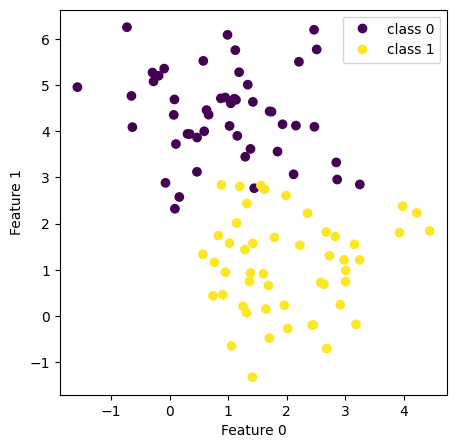

In [11]:
fig = plt.figure(figsize=(5,5))
scatter = plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(handles=scatter.legend_elements()[0], labels=["class 0", "class 1"]);

Note that above we have used a parameter c in the scatter. This parameter allows to us to pass a sequence of numbers to be mapped to colors. In our case we are passing the value of y, which can be either 0 and 1, meaning that the plot will color the point of class 0 with one color, and the points of class 1 with another color.

Now let’s train a Logistic Regression model:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

In [15]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

Just like with Linear Regression, with the `fit` method, we learn the values of the model parameters, $\theta$s from the training data. We can check the estimated values.

In [17]:
print("coefficients: ", log_reg.coef_)
print("intercept: ", log_reg.intercept_)

coefficients:  [[ 0.44216048 -2.4798559 ]]
intercept:  [6.04928457]


Let's visualize the decision boundary using DecisionBoundaryDisplay visualization. We will also visualize the model’s estimated probabilities of belonging to a class with the help of `predict_proba` method.
In the case of a binary classifier:
- `predict` will give the predicted class
- `predict_proba` gives the probabilities for the classes. 

The first entry in each row returned by `predict_proba` is the estimated probability of the class 0, and the second
entry is the estimated probability of  class 1. Because it is a probability, the output of `predict_proba` is always between 0 and 1, and the sum of the entries for both classes is always 1.

Text(0.5, 1.0, 'Decision Boundary of Logistic Regression')

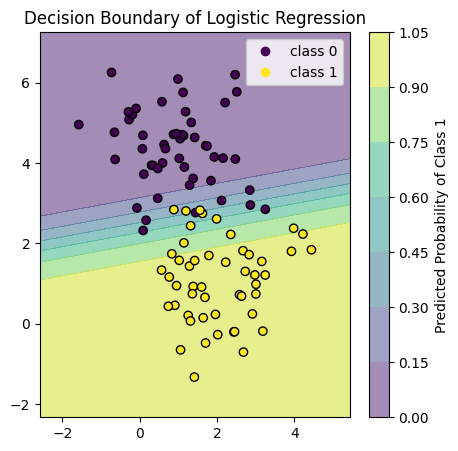

In [20]:
plt.figure(figsize=(5,5))
ax = plt.axes()
disp = DecisionBoundaryDisplay.from_estimator(log_reg, X, response_method="predict_proba", alpha=0.5, ax=ax)
scatter=ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
handles, labels = scatter.legend_elements()
cbar = plt.colorbar(disp.surface_, ax=ax)
cbar.set_label("Predicted Probability of Class 1")
ax.legend(handles=scatter.legend_elements()[0], labels=["class 0", "class 1"])
ax.set_title("Decision Boundary of Logistic Regression")

Decision boundary separates the area classified as class 0 on the top from the area classified as class 1 on the bottom. In other words, any new data point that lies above the boundary will be classified as class 0, while any point that lies below the boundary line will be classified as class 1.

Are the probabilities equal in the whole region where class 1 is predicted? Where is the probability the highest, where the lowest?

For a point with Feature 1 equal to 1 and Feature 2 equal to -1, what class is predicted?

In [24]:
log_reg.predict([[1, -1]])

array([1])

What is the probability of belonging to class 1 for a such a point?

In [26]:
log_reg.predict_proba([[1, -1]])

array([[1.26986733e-04, 9.99873013e-01]])

In [27]:
log_reg.predict_proba([[1, -1]])[0][1]

0.9998730132672156

Where would we put decision boundary if we decided that we should not misclassify any point of class 1 in our training dataset? 
What should be the threshold for probability of belonging to class 1?
We will explore this in detail later on.

Similarly to the case of regression, linear models for classification might seem very restrictive in low-dimensional spaces, only allowing for decision boundaries that are straight lines or planes. In high dimensions, linear models for classification become very powerful, and guarding against overfitting becomes increasingly important when considering more features.

## Regularized Models

Just like the other linear models, Logistic Regression models can be regularized using
L1 or L2 penalties. `sklearn` actually adds an L2 penalty by default. The hyperparameter controlling the regularization strength of a `sklearn` LogisticRegression model is not $\alpha$ (as in other linear models), but its inverse: C. The higher the value of C, the less the model is regularized.

Let’s analyze  Logistic Regression in more detail using another dataset from `sklearn` Breast Cancer dataset.

In [33]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()

Check the details of the dataset with `bc.DESCR`.

In [35]:
print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

Recall that that all of `sklearn datasets` are divided into `data` and `target`. 
`data` represents the features, which are the variables that help the model learn how to predict.
`target` includes the actual labels. For this dataset, the target data is a label that identifies the tumor as either 0 indicating malignant or 1 for benign.

In [37]:
Counter(bc.target)

Counter({1: 357, 0: 212})

As we discussed before, we need to use an independent data set for evaluation, hence we will split the data that we have into training and test dataset.

In [39]:
from sklearn.model_selection import train_test_split

The parameter `test_size`  defines the proportion of the dataset to include in the test split and by default it is 0.25, meaning 25% of the dataset will be used for test.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, random_state=42)

We will now train our model on the training dataset. One of the parameters of Logistic Regression, `solver` corresponds to the type of algorithm to be used in the optimization problem.

In [43]:
log_reg = LogisticRegression(solver='liblinear').fit(X_train, y_train)

What metric can we use to check the performance of the model? For now, we can use *accuracy*: which is the fraction of points for which the right class was predicted. For this we can use the `score` method of the `LogisticRegression` object, which will compute the accuracy.

In [45]:
print('Training set score:' , log_reg.score(X_train, y_train))
print('Test set score: ', log_reg.score(X_test, y_test))

Training set score: 0.9577464788732394
Test set score:  0.958041958041958


Note that each estimator has a score method providing a default evaluation criterion for the problem they are designed to solve. Not all estimators use *accuracy* as a default, so always check the model's `sklearn`'s documentation before you use `score`.

The default value of `C=1` provides quite good performance, with 95% accuracy on both the training and the test set. Let’s try to increase C to fit a more flexible model:

In [48]:
log_reg200 = LogisticRegression(solver='liblinear', C=200).fit(X_train, y_train)

In [49]:
print('Training set score:' , log_reg200.score(X_train, y_train))
print('Test set score: ', log_reg200.score(X_test, y_test))

Training set score: 0.9741784037558685
Test set score:  0.965034965034965


Using C=200 results in higher training set accuracy, and also a slightly increased test set accuracy, so a more complex model  performs slightly better.

We can also investigate what happens if we use an even more regularized model than
the default of C=1, by setting C=0.0001:

In [52]:
log_reg0001 = LogisticRegression(solver='liblinear',C=0.0001).fit(X_train, y_train)

In [53]:
print('Training set score:' , log_reg0001.score(X_train, y_train))
print('Test set score: ', log_reg0001.score(X_test, y_test))

Training set score: 0.9131455399061033
Test set score:  0.951048951048951


In this case, we increased the importance of the penalty term too much and ended up with slightly underfitted model.

Let's compare the coefficients obtained with different values of the parameter C.

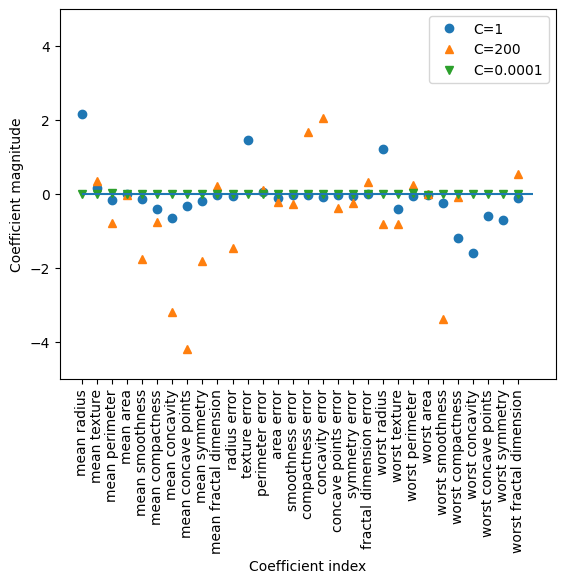

In [56]:
plt.plot(log_reg.coef_.T, 'o', label="C=1")
plt.plot(log_reg200.coef_.T, '^', label="C=200")
plt.plot(log_reg0001.coef_.T, 'v', label="C=0.0001")
plt.xticks(range(bc.data.shape[1]), bc.feature_names, rotation=90)
plt.hlines(0, 0, bc.data.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()

Are our results consistent with the results obtained when applying L2 regularization for Linear Regression?

If we wish to have a more interpretable model, using L1 regularization might help, as it limits
the model to using only a few features. 

In [59]:
log_reg_L100 = LogisticRegression(C=100, solver='liblinear', penalty='l1').fit(X_train, y_train)
print('Training set score:' , log_reg_L100.score(X_train, y_train))
print('Test set score: ', log_reg_L100.score(X_test, y_test))

Training set score: 0.9882629107981221
Test set score:  0.972027972027972


We know that the feature names are in the array `bc.feature_names`, and that the corresponding coefficients in the array `log_reg_L100.coef_`, so we can check which feature are the ones that were selected, i.e, that have a non zero coefficient:

In [61]:
bc.feature_names[log_reg_L100.coef_[0] > 0]

array(['mean radius', 'mean perimeter', 'mean compactness',
       'mean symmetry', 'texture error', 'concavity error',
       'worst radius', 'worst perimeter', 'worst compactness'],
      dtype='<U23')

In [62]:
log_reg_L1 = LogisticRegression(C=1, solver='liblinear', penalty='l1').fit(X_train, y_train)
print('Training set score:' , log_reg_L1.score(X_train, y_train))
print('Test set score: ', log_reg_L1.score(X_test, y_test))

Training set score: 0.960093896713615
Test set score:  0.958041958041958


In [63]:
bc.feature_names[log_reg_L1.coef_[0] > 0]

array(['mean radius', 'mean texture', 'texture error', 'worst perimeter'],
      dtype='<U23')

In [64]:
log_reg_L001 = LogisticRegression(C=0.001, solver='liblinear', penalty='l1').fit(X_train, y_train)
print('Training set score:' , log_reg_L001.score(X_train, y_train))
print('Test set score: ', log_reg_L001.score(X_test, y_test))

Training set score: 0.9154929577464789
Test set score:  0.9230769230769231


In [65]:
bc.feature_names[log_reg_L001.coef_[0] > 0]

array(['mean perimeter', 'mean area'], dtype='<U23')

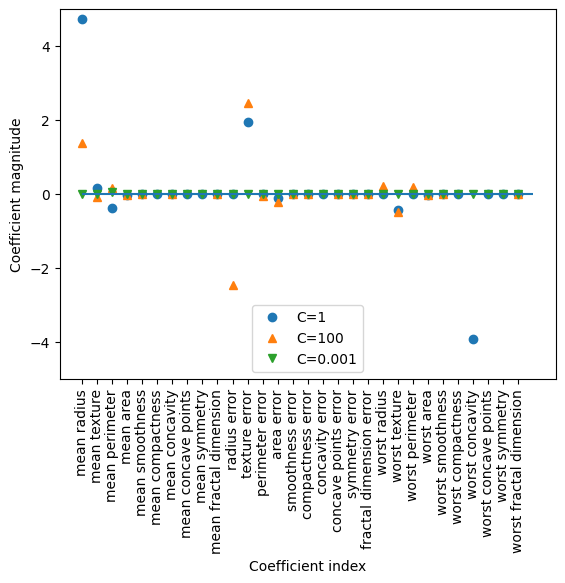

In [66]:
plt.plot(log_reg_L1.coef_.T, 'o', label="C=1")
plt.plot(log_reg_L100.coef_.T, '^', label="C=100")
plt.plot(log_reg_L001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(bc.data.shape[1]), bc.feature_names, rotation=90)
plt.hlines(0, 0, bc.data.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()

How do these results compare with the results of applying L1 regularization for Linear Regression?

## Practice question

Load the Iris dataset from `sklearn` and apply Logistic Regression to detect the Iris-Virginica type. To do so, group the other two classes together (Iris dataset has 3 classes, and we want to use it for binary classification, so we will group 2 classes together).

You might want to use `y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0`

Split the dataset into train and test, and calculate accuracy using different types (L1, L2) and levels (values of C) of regularization.

# Model Evaluation

Parts of this notebook are from the Chapter 5 of the book [Introduction to Machine Learning](https://github.com/amueller/introduction_to_ml_with_python) by Andreas C. Müller & Sarah Guido.

## Classification Metrics

Let us first import a data set about wine quality. The dataset is available in [UCI repository](https://archive.ics.uci.edu/ml/datasets/wine+quality), and you have the downloaded csv.
 
First, let's import the csv you downloaded with this notebook into a panda dataframe. Make sure the dataset is in the same directory as where you placed the notebook. The default separator for reading cvs files is ',' so we need to specify that in our csv file, the columns are separated with ';'. 

In [75]:
df=pd.read_csv('winequality-white.csv', sep=';')

Let's take a look at the first 5 lines of our dataset using the `head()` method.

In [77]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

Now, let's get some info on our dataset using the `info()` method.

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Notice that we have 4,898 data instances (rows) and 11 float features and an integer feature `quality` which we will use to construct the target. Let's check the statistics of the numerical columns (in our case, all the features are numerical), using the `describe()` method.

In [81]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

The same output can be printed out by reversing rows and columns, i.e., by transposing it, and it might increase readabilty.

In [83]:
df.describe().T

count        mean        std      min         25%  \
fixed acidity         4898.0    6.854788   0.843868  3.80000    6.300000   
volatile acidity      4898.0    0.278241   0.100795  0.08000    0.210000   
citric acid           4898.0    0.334192   0.121020  0.00000    0.270000   
residual sugar        4898.0    6.391415   5.072058  0.60000    1.700000   
chlorides             4898.0    0.045772   0.021848  0.00900    0.036000   
free sulfur dioxide   4898.0   35.308085  17.007137  2.00000   23.000000   
total sulfur dioxide  4898.0  138.360657  42.498065  9.00000  108.000000   
density               4898.0    0.994027   0.002991  0.98711    0.991723   
pH                    4898.0    3.188267   0.151001  2.72000    3.090000   
sulphates             4898.0    0.489847   0.114126  0.22000    0.410000   
alcohol               4898.0   10.514267   1.230621  8.00000    9.500000   
quality               4898.0    5.877909   0.885639  3.00000    5.000000   

                            50%       75%        max  
fixed acidity           6.80000    7.3000   14.20000  
volatile acidity        0.26000    0.3200    1.10000  
citric acid             0.32000    0.3900    1.66000  
residual sugar          5.20000    9.9000   65.80000  
chlorides               0.04300    0.0500    0.34600  
free sulfur dioxide    34.00000   46.0000  289.00000  
total sulfur dioxide  134.00000  167.0000  440.00000  
density                 0.99374    0.9961    1.03898  
pH                      3.18000    3.2800    3.82000  
sulphates               0.47000    0.5500    1.08000  
alcohol                10.40000   11.4000   14.20000  
quality                 6.00000    6.0000    9.00000

Let's now check the distribution of the attribute `quality` using the method `value_counts()`.

In [85]:
df['quality'].value_counts()

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64

This is not a binary classification problem, the target has more than two different values – so we will turn it into one. Let's say the wine is Good (label 1) if the quality is 7 or above, and Bad (label 0) otherwise:

In [87]:
df['target']=0
df.loc[df.quality>=7,'target']=1
# alternatively we could have written df['target']=[1 if quality>=7 else 0 for quality in df['quality']]
df['target'].value_counts()

target
0    3838
1    1060
Name: count, dtype: int64

We can plot the percentages of the target variable. The method `value_counts` if used with parameter `normalize=True` will return the relative frequencies of the unique values.

Text(0.5, 0, 'type of wine')

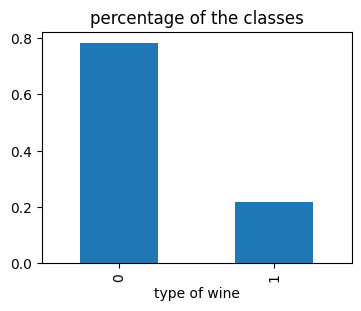

In [89]:
ax=df['target'].value_counts(normalize=True).plot(kind='bar', figsize=(4, 3))
ax.set_title('percentage of the classes')
ax.set_xlabel('type of wine')

We used pandas plot method and specified a bar plot using the parameter `kind`; there are many other options available: line, histogram, boxplot,...

Notice that we have quite the common case where we do not have the same percentage of classes, bad wines (class 0) are more common than our good ones: we have an *imbalanced* dataset. This makes it harder for the algorithm to learn the patterns of the class which is a minority. There are different techniques for dealing with such datasets, but we will only discuss them later.

Let's now drop the column we used to construct our target, otherwise the model could just learn the simple mapping from `quality` to `target`. However such a model would be absolutely useless in practice, it could classify the wine as good or bad only if it knew its quality; but then, if we knew the wine's quality, we would not even need an ML model! If we used the column `quality` in the model training, it would be an example of **data leakage**: the use of information in the model training process which would not be expected to be available at prediction time. We will discuss this in more detail later on.

In [93]:
df.drop(columns='quality', inplace=True)

And let's check the names of our columns using `columns` method.

In [95]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'target'],
      dtype='object')

Now, let's see do we have missing data, with `isnull().sum()`.

In [97]:
 df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
target                  0
dtype: int64

We do not have any missing values, so we can proceed with classification. To see the generalization performance of our model, we need to use a holdout set: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance. 

In [99]:
from sklearn.model_selection import train_test_split
X=df.drop(columns='target')
y=df['target']
# split the data with 50% in each set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

Now check the shape of `X_train`, `X_test`, `y_train`, `y_test`.

In [101]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3673, 11)
(1225, 11)
(3673,)
(1225,)


Let's scale our data. It is not necessary for basic Logistic Regression, but it is recommended in regularized versions, and `sklearn` by default uses L2 regularization.

In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Notice that we are learning the parameter for scaling only from the train data, as we do the `fit` method only on the X_train. Then we `transform` both train and test set using the parameters learned from the fitting on the training data only.

Let's now classify using Logistic Regression. Note that we will use the train dataset to train our model, and we will use the test dataset to evaluate it.

In [106]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train) 

LogisticRegression(random_state=42, solver='liblinear')

Recall that `sklearn` method `predict` outputs the predicted class, while `predict_proba` outputs the probability of belonging to a class. The default threshold for deciding the classes in the case of binary classification is 0.5, hence Logistic Regression chooses the class that has the biggest probability: outputs 1 if $P(Y=1|x) >= 0.5$ (then obviously $P(Y=0|x) <P(Y=1|x)$). 

In [108]:
#generate predicted classes for test data
y_pred= log_reg.predict(X_test)
#generate predicted probabilites for test data
y_pred_prob = log_reg.predict_proba(X_test)


Now let's look at some evaluation metrics.

### Confusion matrix


The predicted classes are represented in the columns of the matrix, whereas the actual classes are in the rows of the matrix. We then have four cases:
- True positives (TP): the cases for which the classifier predicted 1 and the the class is actually 1.
- True negatives (TN): the cases for which the classifier predicted 0 and the class is actually 0.
- False positives (FP): the cases for which the classifier predicted 1 but class is actually 0.
- False negatives (FN): the cases for which the classifier predicted 0 but the the class is actually 1.

The entries of the confusion matrix are the number of occurrences of each class for the dataset being analyzed. Let's obtain the confusion matrix by using the function `confusion_matrix`:

[[887  54]
 [206  78]]
target
0    941
1    284
Name: count, dtype: int64


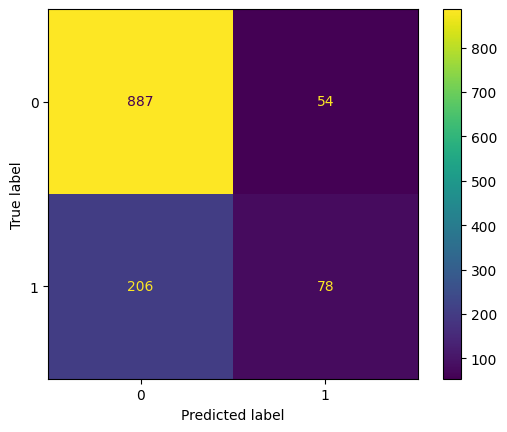

In [112]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
cm=confusion_matrix(y_test, y_pred)
print(cm)
print(y_test.value_counts())
ConfusionMatrixDisplay(cm).plot();

Let's interpret these values:
Out of the 284 instances of class 1 in our test set, the model identified 78 of them as 1, and 206 predicted as 0 (false negatives, type II error).
Out of 941 wines of class 0, 887 were identified correctly as 0, and 54 were false positives (type I error).

### Accuracy, Precision, Recall, f1 score, MCC


There are many different metrics we could check.

**Accuracy**: answers the question: "How many decisions did we get right?"
\begin{equation}
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

**Precision**: answers the question:
"When it predicts the positive result, how often is it correct?"

\begin{equation}
\text{Precision} = \frac{TP}{TP + FP}
\end{equation}

**Recall**: answers the question: "How many instances of positive class did it actually identify?"

\begin{equation}
\text{Recall} = \frac{TP}{TP + FN}
\end{equation}

**F1-score**: is just the harmonic mean of precision and recall:

\begin{equation}
\text{f1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\end{equation}

These are the most well known metrics, but others may be considered as well. For instance, we know that Accuracy results can be misleading in imbalanced cases (the model may simply predict the majority class well and achieve a high score). Also, notice that Precision, Recall and f1-score, by extension, focus on the positive class (True Negatives are not included), which has some implications. Consider the following examples:

`Positively Imbalanced Dataset Results` – TP = 90, FN = 1, TN = 0, FP = 9 (good class 1 predictions, poor class 0 predictions)  
- Accuracy = 0.90  
- f1-score = 0.95

This model is biased toward predicting the positive class. If class 1 is much more important, it might be acceptable. However, if predictions for class 0 matter significantly, the model is not suitable (TN is 0, denoting the deficient performance for the negative class).

`Negatively Imbalanced Dataset Results` – TP=2, FN=9, TN=88, FP=1 (poor class 1 predictions, good class 0 predictions)  
- Accuracy = 0.90  
- f1-score = 0.29

This model is biased toward predicting the negative class. If class 0 predictions are more critical, it might be acceptable. However, if class 1 predictions are relevant, this model is inadequate (TP is 2 when there are 11 positives, indicating the insufficient performance for the positive class).

What does this imply?

If we only looked at the accuracy, both models would seem useful. Conversely, the f1-score only realized that the performance is not adequate in the second case, while in the first, since the positive class predictions were good, f1-score was high; **thus, the f1-score (and, by extension, precision and recall), by default, focus on the performance of the positive class (as the formulas display)**, and in many cases, for example in the detection of fraud, diseases, or other rare events, there are fewer positive instances.

#### Additional discussion on MCC (optional)

Given the convention that rarer or more "interesting" samples are usually labeled as positive and the majority class is negative, such as in problems where the patients have a rare disease (they are tested positive), the f1-score usually fulfills its purpose of being a good metric by placing more emphasis on the positive class.

However, in cases where the model must perform well on both the positive and the negative classes, a metric that considers all four confusion matrix elements (TN, TN, FP, FN) may be needed. One such metric is the Matthews Correlation Coefficient (MCC).

\begin{equation}
\text{Matthews Correlation Coefficient (MCC)} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
\end{equation}

MCC is the only binary classification rate that generates a high score only if the binary predictor was able to correctly predict the majority of positive data instances and the majority of negative data instances.

In the previous cases, the MCC would be -0.03 for the positive imbalance, and +0.31 for the negative imbalance, reflecting the inadequate model performance in both scenarios.

It ranges in the interval [−1, +1], with extreme values –1 and +1 reached in case of perfect misclassification and
perfect classification, respectively, while MCC = 0 means the model is no better than random guessing.

The key advantage of the Matthews correlation coefficient is that it generates a high quality score **only if the prediction correctly classified a high percentage of negative data instances and a high percentage of positive data instances, regardless of class balance or imbalance.**

#### Metrics in sklearn

There is a trade-off between optimizing recall and optimizing precision. We can trivially obtain a perfect recall if we predict all samples to belong to the positive class—there will be no false negatives, and no true negatives either. However, predicting all samples as positive will result in many false positives, and therefore the precision will be very low. On the other hand, if we find a model that predicts only the single data point it is most sure about as positive and the rest as negative, then precision will be perfect (assuming this data point is in fact positive), but recall will be very bad.

`Sklearn` offers a report on all the metrics for all the classes (except MCC).

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       941
           1       0.59      0.27      0.38       284

    accuracy                           0.79      1225
   macro avg       0.70      0.61      0.62      1225
weighted avg       0.76      0.79      0.76      1225



The `classification_report` function produces one line per class and reports precision, recall, and f1-score with this class as the positive class.
The last column next to the f1-score provides the support of each class, which simply means the number of samples in this class according to the ground truth.

The second to last row in the classification report shows macro averaged metrics, meaning it simply finds the average of the metrics calculated per class (the first two rows).
The last row shows a weighted (by the number of samples in the class) average of the numbers for each class. 

These two rows show different values, since we have a case when the two classes have unequal distribution. In macro averaging we treat both classes the same, but in weighted we give more weight to the class with more instances (class 0 in our case). Since class 0 has much higher metrics than class 1, hence weighted averaging gives higher values. More details on this combining is given in the section [Multiclass Classification metrics](#Multiclass-classification).

We could check the metrics individually.

In [125]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, matthews_corrcoef

print('accuracy is ', accuracy_score(y_test, y_pred))
print('precision is', precision_score(y_test, y_pred))
print('recall is', recall_score(y_test, y_pred))
print('F1 score is', f1_score(y_test, y_pred))
print('MCC is', matthews_corrcoef(y_test, y_pred))

accuracy is  0.7877551020408163
precision is 0.5909090909090909
recall is 0.2746478873239437
F1 score is 0.375
MCC is 0.29569294526703777


Note that the accuracy seems relatively high compared to other metrics, this is because the dataset in imbalanced, and the model does a much better job for majority class 0, compared to class 1. Accuracy calculates the overall number of correct decisions, while the other metrics refer to class 1.

### ROC, ROC AUC, Precision Recall Curves, PR AUC 

So far, we have only considered the threshold of 0.5, and we did not look at the overall performance of the classifier. 
Let's now check the metrics which show the model performance for all the possible thresholds.
Receiver operating characteristic (ROC) curve is created by plotting the true positive rate (TPR) (or recall) against the false positive rate:

\begin{equation}
\text{TPR} = \frac{TP}{TP + FN}
\end{equation}


\begin{equation}
\text{FPR} = \frac{FP}{FP + TN}
\end{equation}
 To get the ROC curve we now need the model's performance for all thresholds, not just the default one (0.5). Hence we will use predicted probabilities for class 1 (`y_pred_prob`), not the predicted class for the default threshold (`y_pred`). Note that when we used the method `predict_proba` we obtained the predicted probabilities for both classes, so the array `y_pred_prob` has two columns, one for each class. We need to use the probabilities of belonging to class 1, hence we choose the second column: `y_pred_prob[:,1]`.

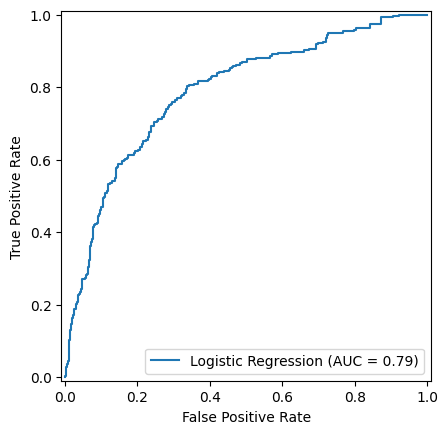

In [129]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc = auc(fpr, tpr)
display=RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

In [130]:
print('ROC AUC is', roc_auc )

ROC AUC is 0.7875087934621544


The function `roc_curve` returns 3 arrays:
- `fpr` which is an array of false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].
- `tpr` which is an array of true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
- `threshold` which is an array of thresholds, where thresholds[0] represents no instances being predicted as 1 and is arbitrarily set to infinity.

Let's use these 3 arrays and replot the ROC curve, but now visualizing the values of the threshold, rounded to 3 decimal places, at some points (every 50th value, step= 50).
We will also find in the array threshold a value closest to 0.5, and plot this in red to visualize the default threshold.

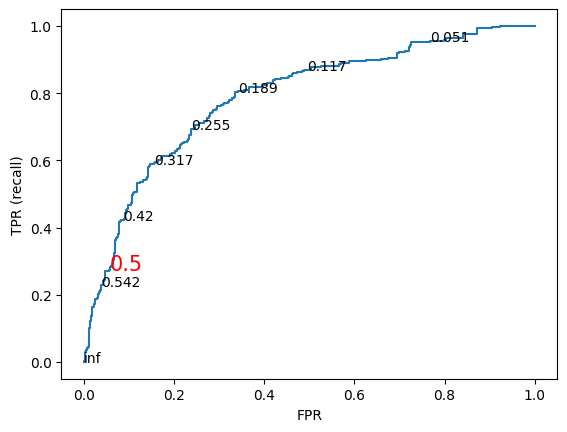

In [133]:
len_thres=len(thresholds)
step=50
idx_05 = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
for i in range(0, len_thres, step):
    plot_value = str(np.round(thresholds[i],3))
    plt.text(fpr[i]  , tpr[i] , plot_value);
plt.text(fpr[idx_05] , tpr[idx_05] , '0.5' , color='red' ,fontdict={'size': 15});
plt.show();

Note:  We found the value in our `thresholds` array closest to 0.5 by finding the value whose difference to 0.5 is the lowest. Note that `np.argmin` return the index of the minimum value:

In [135]:
idx_05, thresholds[idx_05]

(64, 0.5008972760184659)

The first value of the threshold is set to a value larger than a probability of any point in the test set: infinity: 

In [137]:
thresholds[0], max(y_pred_prob[:,1])

(inf, 0.8896254896560013)

How did we plot the values of the threshold on the plot below? We converted the values of the threshold, rounded to 3 decimal points,  to a string and used `matplotlib.pyplot` method `text` to plot these values.

Note that we could have plotted the ROC curve directly using the trained model, in or case named *log_reg*, and the data, with *RocCurveDisplay.from_estimator*.

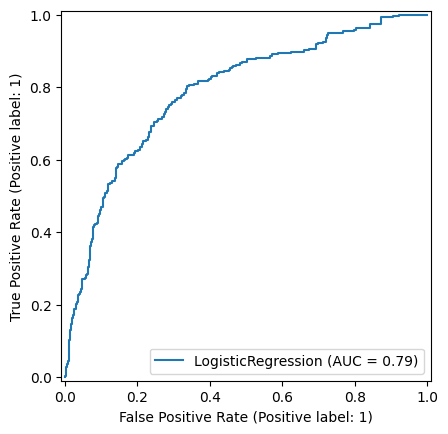

In [140]:
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)


Now, let's look at the precision recall curve.

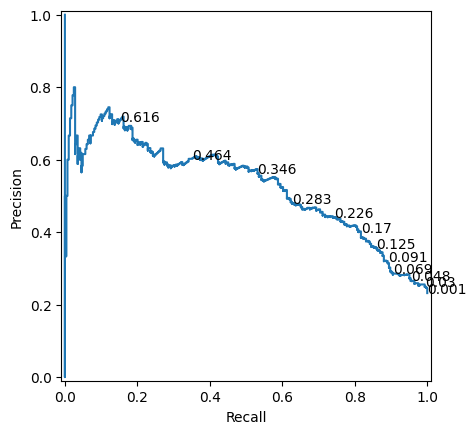

In [154]:

step=100
from sklearn.metrics import  precision_recall_curve, PrecisionRecallDisplay
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
len_thres=len(thresholds)
display = PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()
for i in range(0, len_thres, step):
    plot_value = str(np.round(thresholds[i],3))
    plt.text(recall[i] , precision[i] , plot_value);


As with the ROC curve, each point in the plot corresponds to a different threshold. Threshold equal to 0 implies that all the points are classified as positive, so the recall is 1.  For this value of the threshold, precision equals roughly 0.2, meaning when all points are classified of positive, only 20% are in fact from the positive class (as we saw when we plotted class distribution.)  
On the other end, when the threshold is larger than the maximum value of the probability, we classify no point as positive, so recall is 0. Now, for precision we have both TP=0, and FP=0, so we get TP/(TP+FP)=0/0. And for this undefined value, `sklearn` sets the precision as 1. Now, it turns out that for our specific dataset and the model we just trained, that the point that is scored the highest is actually negative, it is a false positive. So, now if we set the threshold value just below the highest probability, we will still have a recall of 0, and now the precision will be 0 as well, since we have 1 FP: 0/(0+1)=0/1=0. But now, our f1 score will not be defined as 0/0, and will have the value of `np.nan` for this value of threshold, as we will see below.

With the precision-recall curve, the closer it is to the top-right corner, the better the algorithm. And hence a larger area under the curve (AUC) indicates that the algorithm has higher recall and higher precision. We can again check the area under the curve AUC using the function `auc`, but now our x-axis is defined with recall and y-axis with precision:

In [144]:
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.5237908848122609


PR AUC is also known as the *average precision* and can be calculated as follows:

In [146]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred_prob[:,1])
print(average_precision)

0.5271591745812503


Again, we can plot the Precision recall curve directly from the estimator:

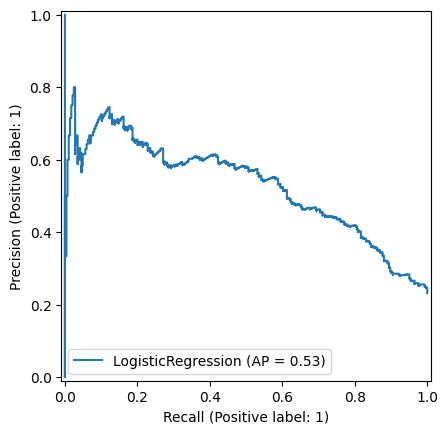

In [148]:
PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test)

AUC is not connected with any particular threshold (we are averaging over all the possible thresholds), and so it doesn't tell us what is the best threshold to consider for useful classification predictions. We could also check what value of threshold would give us the highest f1 score. Important note: we are looking at the best possible threshold to illustrate how this can be done. But, **we should not use the test set to make any modeling decision, including finding the value of the threshold**. So if we chose the threshold on this set, we **cannot** use it for the final independent evaluation. Then we would need one more hold out set for actual independent evaluation. We will discuss this later on, but for now we will just illustrate how to find the threshold that maximizes f1 score assuming that we still need to do independent evaluation on another dataset.

In [150]:
f1_scores = 2*recall*precision/(recall+precision)
idx_best=np.nanargmax(f1_scores)
best_threshold=thresholds[idx_best]
print('Best threshold: ', best_threshold)
print('Best f1-Score: ', np.nanmax(f1_scores))

Best threshold:  0.3209670775059126
Best f1-Score:  0.567062818336163


C:\Users\sabina\AppData\Local\Temp\ipykernel_6632\1637276211.py:1: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)


Notice that we received a warning of an invalid value, and this is for the case when both precision and recall are 0. Hence we used `np.nanargmax` to find the index of the maximum value, while ignoring nans.

Let's replot the precision recall curve with some values of the threshold, and label the value that maximizes the f1-score.

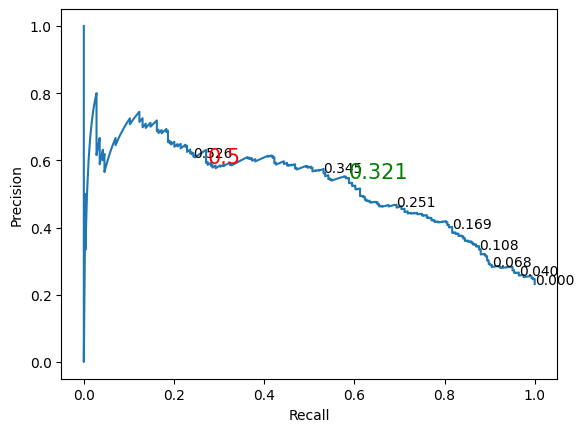

In [153]:
len_thres=len(thresholds)
step=150
idx_05 = np.argmin(np.abs(thresholds - 0.5))
plt.plot( recall, precision,label="PR Curve")
plt.ylabel('Precision')
plt.xlabel('Recall')
for i in range(0, len_thres, step):
    plot_value = str(thresholds[i])[:5]
    plt.text( recall[i]  , precision[i]  , plot_value);
plt.text( recall[idx_best] , precision[idx_best],  "%.3f" %best_threshold, color='green',fontdict={'size': 15})
plt.text( recall[idx_05], precision[idx_05]  , '0.5' , color='red' ,fontdict={'size': 15});
plt.show();

Let's now check the confusion matrix if we used the threshold that maximizes f1.

In [155]:
print('previous confusion matrix')
print(confusion_matrix(y_test, y_pred))

print('previous metrics')
print(classification_report(y_test, y_pred))


previous confusion matrix
[[887  54]
 [206  78]]
previous metrics
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       941
           1       0.59      0.27      0.38       284

    accuracy                           0.79      1225
   macro avg       0.70      0.61      0.62      1225
weighted avg       0.76      0.79      0.76      1225



In [156]:
y_pred_new = (y_pred_prob[:,1] >= best_threshold).astype(int)

print("new confusion matrix")
print(confusion_matrix(y_test, y_pred_new))

print('new metrics')
print(classification_report(y_test, y_pred_new))

new confusion matrix
[[803 138]
 [117 167]]
new metrics
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       941
           1       0.55      0.59      0.57       284

    accuracy                           0.79      1225
   macro avg       0.71      0.72      0.72      1225
weighted avg       0.80      0.79      0.79      1225



Notice that for slightly lower precision, with this new threshold we have a much better recall, and better f1 score (for class 1). 

But as discussed above, since we chose the threshold on this dataset, we cannot use it for the final evaluation. In practice, we would first divide the dataset set in three: train, validation and test. Then we could use the train dataset to train the model, validation to make modelling decisions, such as choosing the threshold, and the final test to evaluate the final model.

Or alternatively, we could split the dataset into train and test, and then use cross validation on the train dataset, as we will see later on. We will discuss these options in the next notebook.

### Cumulative response and lift curves


We will use an additional library, `sklearn-evaluation`: please install it in your environment:

`pip install sklearn-evaluation`


Cumulative response curve is similar to ROC, but more intuitive. 
It plots the hit rate (true positive rate; y-axis), i.e., the percentage of positives correctly classified, as a function  of the percentage of the population that is targeted (x-axis). Note that the population on the x-axis is ordered according to their score or probability of belonging to class 1: the data points with the highest probability of belonging to class 1 are first, and those with a lower probability follow. 

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

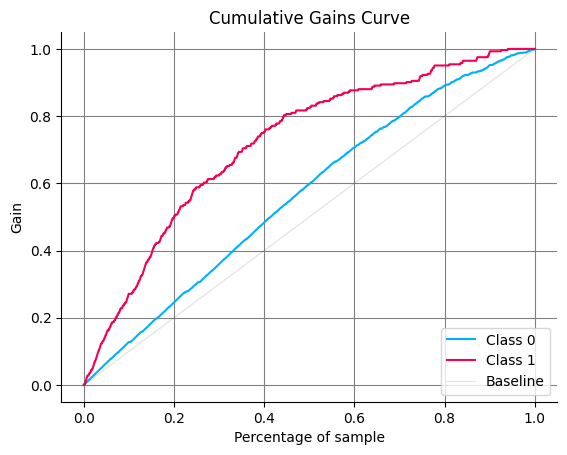

In [161]:
from sklearn_evaluation.plot import cumulative_gain
cumulative_gain(y_test, y_pred_prob)

Looking at the plot above, if we target 20% of the population ranked by their decreasing score (value 0.2 on the x-axis), what is the proportion of instances of class 1 we will reach (corresponding value on the y-axis of the orange curve)? If we had a random classifier, those two values would be the same (fall on the diagonal), but if a classifier was better than random, by targeting top 20% of the population with the highest probability of belonging to class 1, we would get more data points of class 1 then present in the random sample. Looking at our Cumulative Gains Curve, we see that we could capture around 50% of instances of class 1.  

The lift curve is essentially the value of the cumulative response curve at a given x point divided by the diagonal line (y=x) value at that point. 

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

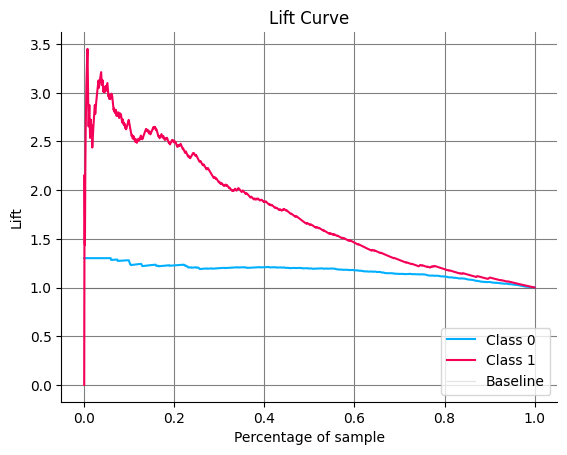

In [164]:
from sklearn_evaluation.plot import lift_curve
lift_curve(y_test, y_pred_prob)

Now looking at the top 20% ranked instances what is the lift of the model for class 1?

Now, what was the answer to the question from the cumulative curve? If we take that percentage and divide by the 20 (as we are considering 20% of the population), what is the value? Compare that to the model lift for 20%.

Note that the maximum value of the lift depends on the class distribution. For example, if we had 100 data points, with 50 of each class, if we target top 10 instances with the highest probability of belonging to class 1, and we had a perfect model, all those 10 instances would be of class 1. Hence, the true positive rate would be 10/50 (total number of class 1)= 0.2. And the corresponding lift would be 0.2/0.1 = 2.

If on the other hand, we had a case of class imbalance, with 10 instances of class 1 and 90 of class 0 and we targeted top 10 instances with the highest probability of belonging to class 1 obtained with a perfect classifier, we would get all 10 instances of class 1, making true positive rate of 10/10=1, and the corresponding gain of 1/0.1=10.

## Multiclass classification

Now that we have discussed the evaluation of binary classification tasks in depth, let's
move on to metrics to evaluate multiclass classification. Basically, all metrics for multiclass classification are derived from binary classification metrics, but they can be averaged in different ways.

Let's load the dataset that contains images of hand-written digits: 10 classes where each class refers to a digit. Each pixel is represented as a feature, where the value of each feature is an integer between 0 and 16. This value indicates the pixel's intensity, with 0 being white and 16 being black.

In [170]:
from sklearn.datasets import load_digits
digits = load_digits()

Check the description of the dataset.

In [172]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

Let's convert the dataset into pandas dataframe.

In [174]:
df = pd.DataFrame(digits.data)
df.columns = digits.feature_names
df['target'] = digits.target

Check the shape of the dataset, name of the features and the distribution of the target variable.

In [176]:
df.shape

(1797, 65)

In [177]:
df.columns

Index(['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4',
       'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1',
       'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6',
       'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3',
       'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0',
       'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5',
       'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2',
       'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7',
       'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4',
       'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1',
       'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6',
       'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3',
       'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7', 'target'],
      dtype='object')

In [178]:
df.target.value_counts()

target
3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: count, dtype: int64

Let's split the dataset intro train and test and apply Logistic Regression to the dataset. Note that Logistic Regression can be used directly for multiclass scenario.

In [180]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
lr = LogisticRegression(solver="liblinear", random_state=42).fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [181]:
print(confusion_matrix(y_test, y_pred))

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  0  0  1  0  1  0]
 [ 0  0 43  1  0  0  0  0  0  0]
 [ 0  0  1 44  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  0  0  0 47  0  0]
 [ 0  4  1  1  0  0  0  0 42  0]
 [ 0  0  0  0  0  1  0  1  1 44]]


For the first class, the digit 0, there are 37 samples in the class, and all of these samples were classified as class 0 (there are no false negatives for class 0). We can see that because all other entries in the first row of the confusion matrix are 0. We can also see that no other digits were mistakenly classified as 0, because all other entries in the first column of the confusion matrix are 0 (there are no false positives for class 0).
Some digits were confused with others, though, for example, the digit 1 (second row), one was classified as 6 and one as 8. Just like in the binary case, we can compute the precision, recall, and f-score for each class using `classification_report` function.

In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.87      0.95      0.91        43
           2       0.96      0.98      0.97        44
           3       0.94      0.98      0.96        45
           4       1.00      0.97      0.99        38
           5       0.98      0.98      0.98        48
           6       0.98      0.98      0.98        52
           7       0.96      0.98      0.97        48
           8       0.95      0.88      0.91        48
           9       1.00      0.94      0.97        47

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



Unsurprisingly, precision and recall are a perfect 1 for class 0, as there are no confusions
with this class. For class 4, on the other hand, precision is 1 because no other
class was mistakenly classified as 4. We can also see that the model has particular difficulties with class 8.

As we discussed above, we can combine per class metrics using one of the following strategies:
-  *macro* averaging computes the unweighted per-class metric. This gives equal weight to all classes, no matter what their size is.
- *weighted* averaging computes the mean of the per-class metric, weighted by their support. This is what is reported in the classification report.
- *micro* averaging computes the total number of false positives, false negatives, and true positives over all classes, and then computes the metric using these counts.

If we care about each sample equally much, it is recommended to use the micro averaging; if we care about each class equally much, it is recommended to use the macro average:

In [185]:
print("Micro average f1 score: ", f1_score(y_test, y_pred, average="micro"))
print("Macro average f1 score: ", f1_score(y_test, y_pred, average="macro"))

Micro average f1 score:  0.9622222222222222
Macro average f1 score:  0.962967615941786


 Consider the following example: 

\begin{array}{|c|c|c|}
\hline
\textbf{Classes} & \textbf{Distribution} & \textbf{Results} & \textbf{Precision} \\
\hline
\text{Class 0} & \text{900 instances (majority class)} & \text{TP = 855, FP = 9} & \text{0.99} \\
\hline
\text{Class 1} & \text{90 instances} & \text{TP = 36, FP = 36} & \text{0.5} \\
\hline
\text{Class 2} & \text{10 instances (minority class)} & \text{TP = 1, FP = 9} & \text{0.1} \\
\hline
\end{array}
\
\
\begin{equation}
{Micro} = \frac{855 + 36 + 1}{855 + 36 + 1 + 9 + 36 + 9} = 0.943
\end{equation}
\
\
\begin{equation}
{Macro} = \frac{0.99 + 0.5 + 0.1}{3} = 0.53
\end{equation}
\
\
\begin{equation}
{Weighted} =\frac{0.99\times900 + 0.5\times90 + 0.1\times10}{1000} = 0.937
\end{equation}
\
\
**Intuition**

- Micro: Every sample is treated equally (classes with more samples are further reflected in the result).
- Macro: Every class is treated equal (unveils poor performance in minority classes).
- Weighted: Balances class sizes (larger classes will still dominate, but minority classes influence the result to a degree).

## Practice question

Now use the breast cancer dataset and apply logistic regression. Evaluate the performance of the algorithm, looking at all of the above metrics on the test set.

# Learning and validation curves

Now, we will take a look at two very simple yet powerful diagnostic tools that can help us to improve the performance of a learning algorithm: learning curves and validation curves.

Let's now import the iris dataset, using the parameter *return_X_y=True* to return the features and label directly. We will also shuffle the data, since the data is sorted by labels, and we want to have data instances of different labels in each fold. In later notebooks, we will return to this and discuss better approach to achieve this, but for now, we will just shuffle the data.

In [192]:
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
X, y = load_iris(return_X_y=True)
X, y = shuffle(X, y, random_state=0)

Let's check the distribution of the target variable.

In [194]:
from collections import Counter 
Counter(y)

Counter({2: 50, 1: 50, 0: 50})

We can visualize model performance for different training and test set sizes using `sklearn's LearningCurveDisplay`. For this visualization, a cross-validation is used, which will be discuss in the next notebook. 

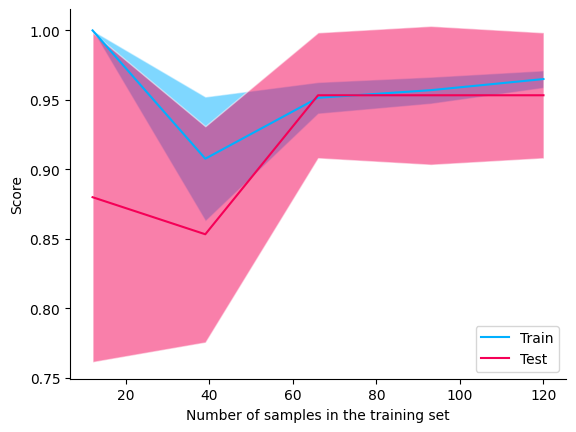

In [196]:
from sklearn.model_selection import LearningCurveDisplay
LearningCurveDisplay.from_estimator(LogisticRegression(solver="liblinear", random_state=42, max_iter=10000), X, y)

From the plot above we can see that for very few data points, the training score of the Logistic Regression is greater than the test score. Adding more training samples increases generalization.

Now that we know how to evaluate how well a model generalizes, we can take the next step and improve the model's generalization performance by tuning its parameters. Many of the algorithms in `sklearn` have parameters that can be tuned and it is important to understand what the parameters mean before trying to adjust them. 

To plot the influence of a single hyperparameter on the training score and the hold out score and to see whether the estimator is overfitting or underfitting for some hyperparameter values, we can use *ValidationCurveDisplay*:

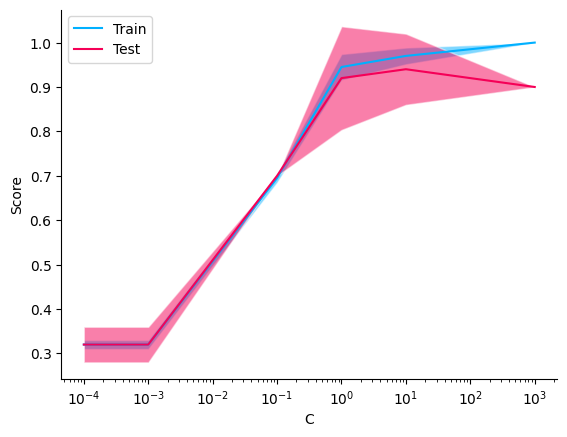

In [200]:
from sklearn.model_selection import ValidationCurveDisplay
ValidationCurveDisplay.from_estimator(LogisticRegression(solver="liblinear", penalty='l1', random_state=42, max_iter=10000),
   X[:50], y[:50], param_name="C", param_range=[0.0001, 0.001, 0.1, 1, 10, 1000])

If the training score and the validation score are both low, the estimator will be underfitting, like we see for C in the range of 0.0001 and 0.001, meaning the regulrization strength is high and the model is too simple. If the training score is higher and the holdout score is lower, the estimator is overfitting, which we see for high values of C (meaning low regularization). And when both the training and the validation are high, the model is working well. Note, to illustrate both of these effects, we used a smaller subset of data.